In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('ijcai2016_taobao_1.csv', sep=r',', engine='python')

In [4]:
df.head()

,use_ID,sel_ID,ite_ID,cat_ID,act_ID,time
0,1980536,9666,1450952,1,0,20150826
1,1980536,9666,1450952,1,0,20150826
2,647747,9666,1450952,1,0,20150915
3,1980536,9666,1450952,1,0,20150823
4,183647,9525,578730,1,0,20150711


In [5]:
df.describe().apply(lambda s: s.apply('{0}'.format))

,use_ID,sel_ID,ite_ID,cat_ID,act_ID,time
count,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0
mean,1024665.8052680527,4550.214902149021,1203661.2412924129,1.0,0.1009310093100931,20150830.19217192
std,596919.0583544845,2805.703221327739,688457.0158119791,0.0,0.3012388556068006,116.58427140128536
min,13.0,60.0,2017.0,1.0,0.0,20150701.0
25%,505223.0,2258.0,594459.0,1.0,0.0,20150720.0
50%,1023194.0,4562.0,1250255.0,1.0,0.0,20150813.0
75%,1542806.0,6792.0,1784092.0,1.0,0.0,20150916.0
max,2063567.0,9995.0,2353171.0,1.0,1.0,20151130.0


In [6]:
data_click = df[['use_ID', 'ite_ID', 'act_ID']].loc[df['act_ID'] == 0]
data_click = data_click.drop_duplicates()

In [7]:
data_buy = df[['use_ID', 'ite_ID', 'act_ID']].loc[df['act_ID'] == 1]
data_buy = data_buy.drop_duplicates()

In [8]:
data_merge = pd.merge(data_click, data_buy, left_on=['use_ID','ite_ID'], right_on=['use_ID','ite_ID'], how = 'left')
data_merge.columns = ['use_ID', 'ite_ID', 'click', 'buy']
data_merge['click'] = data_merge['click'].replace(0, 1)
data_merge['buy'] = data_merge['buy'].fillna(0)

data_merge.head()

,use_ID,ite_ID,click,buy
0,1980536,1450952,1,0.0
1,647747,1450952,1,0.0
2,183647,578730,1,0.0
3,723956,28301,1,0.0
4,1781938,28301,1,0.0


In [9]:
data_click.shape , data_buy.shape, data_merge.shape

((66802, 3), (8391, 3), (66802, 4))

In [10]:
data_merge.loc[data_merge['buy'] == 0].shape, data_merge.loc[data_merge['buy'] == 1].shape

((64808, 4), (1994, 4))

In [11]:
msk = np.random.rand(len(data_merge)) < 0.8
train = data_merge[msk]
test = data_merge[~msk]

In [12]:
train.shape, test.shape

((53548, 4), (13254, 4))

In [13]:
x_train = train.iloc[:, 0:-2].values
y_train = train.iloc[:,3].values

x_train = np.expand_dims(x_train, axis=1)
y_train = np.expand_dims(y_train, axis=1)
y_train = np.expand_dims(y_train, axis=-1)

x_test = test.iloc[:, 0:-2].values
y_test = test.iloc[:,3].values

x_test = np.expand_dims(x_test, axis=1)
y_test = np.expand_dims(y_test, axis=1)
y_test = np.expand_dims(y_test, axis=-1)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((53548, 1, 2), (53548, 1, 1), (13254, 1, 2), (13254, 1, 1))

In [14]:
num_users = 2353171+1
num_items = 2353171+1

In [15]:
num_users, num_items

(2353172, 2353172)

In [16]:
from keras.layers import Embedding, Input, Dense, merge, Reshape, Flatten, Dropout
from keras.regularizers import l2
from keras.optimizers import Adagrad, Adam, SGD, RMSprop

layers = [20,10]
reg_layers=[0,0]
num_layer = len(layers)
learning_rate = 10e-4

## Tạo lớp input kích thước (None, 32, 32, 1)
inputs = tf.keras.layers.Input(shape=(1, 2))

Embedding_User = Embedding(
    input_dim = num_users, 
    output_dim = 64, name = 'user_embedding',
    embeddings_initializer = 'uniform', embeddings_regularizer = l2(reg_layers[0]), input_length=1)

Embedding_Item = Embedding(
    input_dim = num_items, 
    output_dim = 64, 
    name = 'item_embedding',
    embeddings_initializer = 'uniform', embeddings_regularizer = l2(reg_layers[0]), input_length=1)

user_latent = Flatten(name = 'user_latent')(Embedding_User(inputs[0]))
item_latent = Flatten(name = 'item_latent')(Embedding_Item(inputs[1]))

vector = tf.keras.layers.Multiply()([user_latent, item_latent])

# for idx in range(0, num_layer):
#     layer = Dense(layers[idx], kernel_regularizer= l2(reg_layers[idx]), activation='relu', name = 'layer_1_%d' %idx)
#     vector = layer(vector)

click_prediction = Dense(1, activation='sigmoid',use_bias=True, 
                         kernel_initializer='lecun_uniform', 
                         name = 'click_prediction')(vector)

outputs = tf.concat([click_prediction], -1)

In [17]:
## Compile model
# with strategy.scope():
model = keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy', 
              metrics=["accuracy","mse",tf.keras.metrics.RootMeanSquaredError()])

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 2)]       0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(1, 2)]             0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(1, 2)]             0           input_1[0][0]                    
__________________________________________________________________________________________________
user_embedding (Embedding)      (1, 2, 64)           150603008   tf_op_layer_strided_slice[0][0]  
______________________________________________________________________________________________

In [19]:
history = model.fit(x_train, y_train, batch_size=200, epochs=100)

Epoch 1/100
268/268 [==============================] - 1s 2ms/step - loss: 0.6839 - accuracy: 0.9626 - mse: 0.2454 - root_mean_squared_error: 0.4953
Epoch 2/100
268/268 [==============================] - 1s 2ms/step - loss: 0.6756 - accuracy: 0.9698 - mse: 0.2412 - root_mean_squared_error: 0.4911
Epoch 3/100
268/268 [==============================] - 1s 2ms/step - loss: 0.6702 - accuracy: 0.9698 - mse: 0.2385 - root_mean_squared_error: 0.4884
Epoch 4/100
268/268 [==============================] - 1s 2ms/step - loss: 0.6659 - accuracy: 0.9698 - mse: 0.2364 - root_mean_squared_error: 0.4862
Epoch 5/100
268/268 [==============================] - 1s 2ms/step - loss: 0.6622 - accuracy: 0.9698 - mse: 0.2345 - root_mean_squared_error: 0.4843
Epoch 6/100
268/268 [==============================] - 1s 2ms/step - loss: 0.6590 - accuracy: 0.9698 - mse: 0.2329 - root_mean_squared_error: 0.4826
Epoch 7/100
268/268 [==============================] - 1s 2ms/step - loss: 0.6560 - accuracy: 0.9698 - mse

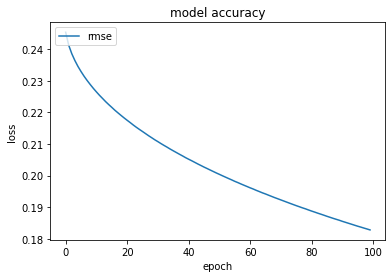

In [20]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['mse'])
# plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['rmse'], loc='upper left')
plt.show()